<a href="https://colab.research.google.com/github/ConorD28/Data-Science-Capping-Project/blob/main/Data_Capping_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
%matplotlib inline
df_alc = pd.read_csv('alcCons.csv')

df_alc["Total Drinks Next Year"] = 0
for i in range(1,len(df_alc), 1):
  if(df_alc["state"][i-1] == df_alc["state"][i]):
    df_alc["Total Drinks Next Year"][i] = df_alc["number_of_drinks_total"][i-1]

df_alc_states = df_alc[df_alc["state"] != "us total"]
df_alc_states = df_alc_states[df_alc_states["state"] != "west region"]
df_alc_states = df_alc_states[df_alc_states["state"] != "south region"]
df_alc_states = df_alc_states[df_alc_states["state"] != "east region"]
df_alc_states = df_alc_states[df_alc_states["state"] != "north region"]
df_alc_states = df_alc_states[df_alc_states["state"] != "midwest region"]
df_alc_states = df_alc_states[df_alc_states["state"] != "northeast region"]

df_alc2 = df_alc_states[df_alc_states["year"] != 2018] #drops rows where year = 2018
df_alc2 = df_alc2.drop(columns=df_alc2.columns[0], axis=1) #drop state so it is not an input
df_alc_target = df_alc_states[df_alc_states["year"] != 2018] #drops rows where year = 2018
df_alc2.drop(columns=df_alc2.columns[-1:], axis=1, inplace = True) #drop target so it is not an input

In [ ]:
df_alc_target

In [ ]:
df_alc.columns

In [ ]:
df_alc2.isnull().sum().sum() #Check if there are NA values

0

In [ ]:
import scipy.stats
def correlation(dataset, threshold, target): #Function to get Pearson's correlation between input and target
  data = []
  for i in range(len(dataset.columns)):
      cor2 = dataset.iloc[:,i].corr(target) #scipy.stats.spearmanr(x, y)[0] and scipy.stats.kendalltau(x, y)[0]
      column_headers = list(dataset.columns.values)
      if(abs(cor2) > threshold):
        data.append(dataset.iloc[:,i]) #make list of columns that meet the threshold
      i = i + 1
  return data

In [ ]:
from sklearn.model_selection import train_test_split
from numpy.random.mtrand import random_sample
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, MultiTaskLassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
def Scores(y, y_pred, y_full):
  MSE = mean_squared_error(y, y_pred)
  MAE = mean_absolute_error(y, y_pred)
  Normalized_RMSE = (np.sqrt(MSE)/np.mean(y_full))*100
  Normalized_MAE = (MAE/np.mean(y_full))*100
  Avg_Normalized_Score = (Normalized_RMSE + Normalized_MAE)/2
  print(f'Avg. Normalized Score:{ Avg_Normalized_Score:.1f}%')
  print(f'Normalized RMSE:{ Normalized_RMSE:.1f}%')
  print(f'Normalized MAE:{ Normalized_MAE:.2f}%')
  #print(f'MAE:{ MAE:.3f}')
  #print(f'RMSE:{ np.sqrt(MSE):.3f}')
  return Avg_Normalized_Score

In [ ]:
def RLE_Model(X, y, choice): #Function to run Ridge, Lasso, or ElasticNet model
  X_train, X_test, y_train, y_test = X[573:1735], X[0:573], y[573:1735], y[0:573]

  if(choice=="Ridge"):
    alphas = np.geomspace(1e-10, 1e10, num=100)
    pipeline = make_pipeline(RidgeCV(alphas=alphas))
    pipeline.fit(X_train, y_train)

  if(choice=="Lasso"):
    alphas = np.geomspace(1e-10, 1e10, num=100)
    pipeline = make_pipeline(LassoCV(alphas=alphas))
    pipeline.fit(X_train, y_train)

  if(choice=="Elastic"):
    l1_ratio = [0, 0.3, 0.5, 0.7, 0.9, 1]
    alphas = np.geomspace(1e-10, 1e10, num=100)
    pipeline = make_pipeline(ElasticNetCV(alphas=alphas, l1_ratio=l1_ratio, max_iter=100000))
    pipeline.fit(X_train, y_train)

  #print(f'Chosen alpha  {pipeline.steps[0][1].alpha_:.6f}')
  #print(f'Intercept (b) {pipeline.steps[0][1].intercept_:.6f}')
  #print(pd.Series(pipeline.steps[0][1].coef_, index=X.columns),'\n')

  #Calculate the predicted values:
  y_train_pred = pipeline.predict(X_train)
  #print(y_train_pred)
  print()

  y_test_pred = pipeline.predict(X_test)

  #Training Scores:
  Avg_N_Score_train = Scores(y_train, y_train_pred, y)
  #print()

  #Test Predictions:
  print("Test predictions:")
  #print(y_test_pred)
  #print()

  #Testing Scores:
  Avg_N_Score_test = Scores(y_test, y_test_pred, y)
  print(f'Difference of avg scores:{ Avg_N_Score_test - Avg_N_Score_train:.3f}%') #Difference between testing and traing scores to check if my bias-variance tradeoff is good
  print()

  #Predict:
  #predictions = pipeline.predict(predict_df)
  #print(predictions)

  return y_test_pred, y_train_pred

In [ ]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

def GBR_model(X,y, t, l, n):
  X_train, X_test, y_train, y_test = X[573:1735], X[0:573], y[573:1735], y[0:573]
  reg = GradientBoostingRegressor(tol = t, learning_rate = l, n_estimators=n, random_state=0) #default: tol = 0.0001, learning rate - 0.1, 100, friedman_mse
  reg.fit(X_train, y_train)
  y_train_pred = reg.predict(X_train)
  #print(y_train_pred)

  y_test_pred = reg.predict(X_test)

  #Training Scores:
  Avg_N_Score_train = Scores(y_train, y_train_pred, y)
  #print()

  #Predictions:
  print("Test predictions:")
  #print(y_test_pred)
  #print()

  #Testing Scores:
  Avg_N_Score_test = Scores(y_test, y_test_pred, y)
  print(f'Difference of avg scores:{ Avg_N_Score_test - Avg_N_Score_train:.3f}%') #Difference between testing and traing scores to check if my bias-variance tradeoff is good
  print()

  #Predict:
  #predictions = reg.predict(predict_df)
  #print(predictions)

  return y_test_pred, y_train_pred

In [ ]:
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb
import pickle

def BR_model(X,y):
  X_train, X_test, y_train, y_test = X[573:1735], X[0:573], y[573:1735], y[0:573]
  reg = BaggingRegressor(base_estimator=xgb.XGBRegressor())
  reg.fit(X_train, y_train)
  y_train_pred = reg.predict(X_train)
  #print(y_train_pred)

  y_test_pred = reg.predict(X_test)

  #Training Scores:
  Avg_N_Score_train = Scores(y_train, y_train_pred, y)
  #print()

  #Predictions:
  print("Test predictions:")
  #print(y_test_pred)
  #print()

  #Testing Scores:
  Avg_N_Score_test = Scores(y_test, y_test_pred, y)
  print(f'Difference of avg scores:{ Avg_N_Score_test - Avg_N_Score_train:.3f}%') #Difference between testing and traing scores to check if my bias-variance tradeoff is good
  print()

  #Predict:
  #predictions = reg.predict(predict_df)
  #print(predictions)

  pickle.dump(reg, open("Drinks_Model", "wb"))

  return y_test_pred, y_train_pred

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#SGD Regressor:
def SGD_model(X,y, t, ep):
  X_train, X_test, y_train, y_test = X[573:1735], X[0:573], y[573:1735], y[0:573]
  reg = make_pipeline(SGDRegressor(max_iter=1000, tol=t, epsilon = ep)) #tol = 0.001, epsilon=0.1
  reg.fit(X_train, y_train)
  reg = pickle.load(open("SGD_Drinks_Model", "rb"))
  y_train_pred = reg.predict(X_train)
  #print(y_train_pred)

  y_test_pred = reg.predict(X_test)

  #Training Scores:
  Avg_N_Score_train = Scores(y_train, y_train_pred, y)
  #print()

  #Predictions:
  print("Test predictions:")
  #print(y_test_pred)
  #print()

  #Testing Scores:
  Avg_N_Score_test = Scores(y_test, y_test_pred, y)
  print(f'Difference of avg scores:{ Avg_N_Score_test - Avg_N_Score_train:.3f}%') #Difference between testing and traing scores to check if my bias-variance tradeoff is good
  print()

  #predictions = reg.predict(predict_df)
  #print(predictions)

  #pickle.dump(reg, open("SGD_Drinks_Model", "wb"))

  return y_test_pred, y_train_pred

In [ ]:
#Keras Sequential Neural Net
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
import os

early_stop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)

def Keras_model(X,y,e, u, u2, u3, u4, u5):
  X_train, X_test, y_train, y_test = X[573:1735], X[0:573], y[573:1735], y[0:573]
  model = Sequential()
  model.add(Dense(u, input_dim=X_train.shape[1], activation='relu')) # Hidden 1, 60
  model.add(Dense(units=u2,activation='relu')) # Hidden 2, 30
  model.add(Dense(units=u3,activation='relu'))
  model.add(Dense(units=u4,activation='relu'))
  model.add(Dense(units=u5,activation='relu'))
  model.add(Dense(units=15,activation='relu')) #15
  model.add(Dense(units=1)) #,activation='relu'
  model.compile(loss='mean_squared_error', optimizer='nadam') #adam, nadam; adamax
  m1 = model.fit(X_train, y_train, verbose=0, epochs=e, callbacks=[early_stop]); #callbacks=[early_stop]

  model.save('Keras_Drinks_Model.h5')
  #model=load_model('Keras_Drinks_Model.h5')
  #model.compile(optimizer = 'nadam', loss = 'mean_squared_error')
  y_train_pred = model.predict(X_train)
  #print(y_train_pred)

  y_test_pred = model.predict(X_test)

  #Training Scores:
  Avg_N_Score_train = Scores(y_train, y_train_pred, y)
  #print()

  #Predictions:
  print("Test predictions:")
  #print(y_test_pred)
  #print()

  #Testing Scores:
  Avg_N_Score_test = Scores(y_test, y_test_pred, y)
  print(f'Difference of avg scores:{ Avg_N_Score_test - Avg_N_Score_train:.3f}%') #Difference between testing and traing scores to check if my bias-variance tradeoff is good
  print()

  return y_test_pred, y_train_pred

In [ ]:
from sklearn.tree import DecisionTreeRegressor

def DTR_model(X,y,leafs):
  X_train, X_test, y_train, y_test = X[573:1735], X[0:573], y[573:1735], y[0:573]
  # We introduce regularization by increasing the value of min_samples_leaf
  tree_reg_regularized = DecisionTreeRegressor(random_state=42, min_samples_leaf=leafs)
  tree_reg_regularized.fit(X_train, y_train)
  y_train_pred = tree_reg_regularized.predict(X_train) #_regularized
  #print(y_train_pred)

  y_test_pred = tree_reg_regularized.predict(X_test) #_regularized

  #Training Scores:
  Avg_N_Score_train = Scores(y_train, y_train_pred, y)
  #print()

  #Predictions:
  print("Test predictions:")
  #print(y_test_pred)
  #print()

  #Testing Scores:
  Avg_N_Score_test = Scores(y_test, y_test_pred, y)
  print(f'Difference of avg scores:{ Avg_N_Score_test - Avg_N_Score_train:.3f}%') #Difference between testing and traing scores to check if my bias-variance tradeoff is good
  print()

  return y_test_pred, y_train_pred

In [ ]:
from sklearn.svm import LinearSVR

def SVM_model(X,y,ep):
  X_train, X_test, y_train, y_test = X[573:1735], X[0:573], y[573:1735], y[0:573]
  svm_reg = LinearSVR(epsilon=ep, random_state=42) #default: epsilon = 0 tol=0.0001, C=1.0
  svm_reg.fit(X_train, y_train)

  #Train Predictions:
  y_train_pred = svm_reg.predict(X_train)
  #print(y_train_pred)

  #Training Scores:
  Avg_N_Score_train = Scores(y_train, y_train_pred, y)
  #print()

  #Test Predictions:
  y_test_pred = svm_reg.predict(X_test)
  print("Test predictions:")
  #print(y_test_pred)
  #print()

  #Testing Scores:
  Avg_N_Score_test = Scores(y_test, y_test_pred, y)
  print(f'Difference of avg scores:{ Avg_N_Score_test - Avg_N_Score_train:.3f}%') #Difference between testing and traing scores to check if my bias-variance tradeoff is good
  print()

  return y_test_pred, y_train_pred

In [ ]:
from sklearn.svm import SVR

def SVM_rbf_model(X,y, choice, ep, C_value):
  X_train, X_test, y_train, y_test = X[573:1735], X[0:573], y[573:1735], y[0:573]

  if(choice=="rbf"):
    model = SVR(kernel="rbf", C=C_value, gamma=0.1, epsilon=ep) #0.1 default ep; 100 default C, 0.1 default gamma
    model.fit(X_train, y_train)

  if(choice=="poly"):
    model = SVR(kernel="poly", C=C_value, gamma="auto", degree=3, epsilon=ep, coef0=1) #0.1 default ep; 100 default C
    model.fit(X_train, y_train)

  if(choice == "linear"):
    model = SVR(kernel="linear", C=C_value, gamma="auto", degree=3, epsilon=ep, coef0=1) #0.1 default ep; 100 default C
    model.fit(X_train, y_train)

  #Train Predictions:
  y_train_pred = model.predict(X_train)
  #print(y_train_pred)

  #Training Scores:
  Avg_N_Score_train = Scores(y_train, y_train_pred, y)
  #print()

  #Test Predictions:
  y_test_pred = model.predict(X_test)
  print("Test predictions:")
  #print(y_test_pred)
  #print()

  #Testing Scores:
  Avg_N_Score_test = Scores(y_test, y_test_pred, y)
  print(f'Difference of avg scores:{ Avg_N_Score_test - Avg_N_Score_train:.3f}%') #Difference between testing and traing scores to check if my bias-variance tradeoff is good
  print()

  return y_test_pred, y_train_pred

# **Naive** **Bayes**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, CategoricalNB

BRFSS = pd.read_csv('BRFSS.csv')

In [ ]:
#NAive Bayes
BRFSS

,Year,Locationabbr,Locationdesc,Class,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,Data_value,Confidence_limit_Low,Confidence_limit_High,Display_order,Data_value_unit
0,2011,AL,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,No,18-24,Age Group,176,50.0,43.6,56.4,8.0,%
1,2011,AL,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,Yes,18-24,Age Group,172,50.0,43.6,56.4,7.0,%
2,2011,AL,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,No,25-34,Age Group,299,47.8,43.0,52.7,10.0,%
3,2011,AL,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,Yes,25-34,Age Group,302,52.2,47.4,57.0,9.0,%
4,2011,AL,Alabama,Alcohol Consumption,Alcohol Consumption,Adults who have had at least one drink of alco...,No,35-44,Age Group,476,51.5,47.3,55.7,12.0,%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96960,2022,WY,Wyoming,Alcohol Consumption,Heavy Drinking,Heavy drinkers (adult men having more than 14 ...,Yes,"Native Hawaiian or other Pacific Islander, non...",Race/Ethnicity,3,NaN,NaN,NaN,4091.0,%
96961,2022,WY,Wyoming,Alcohol Consumption,Heavy Drinking,Heavy drinkers (adult men having more than 14 ...,No,"Other, non-Hispanic",Race/Ethnicity,0,NaN,NaN,NaN,4092.0,%
96962,2022,WY,Wyoming,Alcohol Consumption,Heavy Drinking,Heavy drinkers (adult men having more than 14 ...,Yes,"Other, non-Hispanic",Race/Ethnicity,0,NaN,NaN,NaN,4093.0,%
96963,2022,WY,Wyoming,Alcohol Consumption,Heavy Drinking,Heavy drinkers (adult men having more than 14 ...,No,"White, non-Hispanic",Race/Ethnicity,3164,92.9,91.8,94.0,4082.0,%


In [ ]:
BRFSS=BRFSS.drop(['Locationabbr', 'Class', 'Topic', 'Data_value', 'Confidence_limit_Low', 'Confidence_limit_High', 'Display_order', 'Data_value_unit'],axis=1)

In [ ]:
BRFSS

,Year,Locationdesc,Question,Response,Break_Out,Break_Out_Category,Sample_Size
0,2011,Alabama,Adults who have had at least one drink of alco...,No,18-24,Age Group,176
1,2011,Alabama,Adults who have had at least one drink of alco...,Yes,18-24,Age Group,172
2,2011,Alabama,Adults who have had at least one drink of alco...,No,25-34,Age Group,299
3,2011,Alabama,Adults who have had at least one drink of alco...,Yes,25-34,Age Group,302
4,2011,Alabama,Adults who have had at least one drink of alco...,No,35-44,Age Group,476
...,...,...,...,...,...,...,...
96960,2022,Wyoming,Heavy drinkers (adult men having more than 14 ...,Yes,"Native Hawaiian or other Pacific Islander, non...",Race/Ethnicity,3
96961,2022,Wyoming,Heavy drinkers (adult men having more than 14 ...,No,"Other, non-Hispanic",Race/Ethnicity,0
96962,2022,Wyoming,Heavy drinkers (adult men having more than 14 ...,Yes,"Other, non-Hispanic",Race/Ethnicity,0
96963,2022,Wyoming,Heavy drinkers (adult men having more than 14 ...,No,"White, non-Hispanic",Race/Ethnicity,3164


In [ ]:
dfw1=pd.get_dummies(BRFSS, dtype = int).drop(['Response_No'], axis=1)
dfw1

,Year,Sample_Size,Locationdesc_Alabama,Locationdesc_Alaska,Locationdesc_All States and DC (median) **,"Locationdesc_All States, DC and Territories (median) **",Locationdesc_Arizona,Locationdesc_Arkansas,Locationdesc_California,Locationdesc_Colorado,...,"Break_Out_Other, non-Hispanic",Break_Out_Overall,Break_Out_Some post-H.S.,"Break_Out_White, non-Hispanic",Break_Out_Category_Age Group,Break_Out_Category_Education Attained,Break_Out_Category_Gender,Break_Out_Category_Household Income,Break_Out_Category_Overall,Break_Out_Category_Race/Ethnicity
0,2011,176,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2011,172,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2011,299,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2011,302,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2011,476,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96960,2022,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
96961,2022,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
96962,2022,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
96963,2022,3164,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
for col in dfw1.columns:
    print(col)

Year
Sample_Size
Locationdesc_Alabama
Locationdesc_Alaska
Locationdesc_All States and DC (median) **
Locationdesc_All States, DC and Territories (median) **
Locationdesc_Arizona
Locationdesc_Arkansas
Locationdesc_California
Locationdesc_Colorado
Locationdesc_Connecticut
Locationdesc_Delaware
Locationdesc_District of Columbia
Locationdesc_Florida
Locationdesc_Georgia
Locationdesc_Guam
Locationdesc_Hawaii
Locationdesc_Idaho
Locationdesc_Illinois
Locationdesc_Indiana
Locationdesc_Iowa
Locationdesc_Kansas
Locationdesc_Kentucky
Locationdesc_Louisiana
Locationdesc_Maine
Locationdesc_Maryland
Locationdesc_Massachusetts
Locationdesc_Michigan
Locationdesc_Minnesota
Locationdesc_Mississippi
Locationdesc_Missouri
Locationdesc_Montana
Locationdesc_Nebraska
Locationdesc_Nevada
Locationdesc_New Hampshire
Locationdesc_New Jersey
Locationdesc_New Mexico
Locationdesc_New York
Locationdesc_North Carolina
Locationdesc_North Dakota
Locationdesc_Ohio
Locationdesc_Oklahoma
Locationdesc_Oregon
Locationdesc_P

In [ ]:
dfw1 = dfw1[[col for col in dfw1.columns if col != 'Response_Yes'] + ['Response_Yes']]

In [ ]:
dfw1

,Year,Sample_Size,Locationdesc_Alabama,Locationdesc_Alaska,Locationdesc_All States and DC (median) **,"Locationdesc_All States, DC and Territories (median) **",Locationdesc_Arizona,Locationdesc_Arkansas,Locationdesc_California,Locationdesc_Colorado,...,Break_Out_Overall,Break_Out_Some post-H.S.,"Break_Out_White, non-Hispanic",Break_Out_Category_Age Group,Break_Out_Category_Education Attained,Break_Out_Category_Gender,Break_Out_Category_Household Income,Break_Out_Category_Overall,Break_Out_Category_Race/Ethnicity,Response_Yes
0,2011,176,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2011,172,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,2011,299,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2011,302,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2011,476,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96960,2022,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
96961,2022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
96962,2022,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
96963,2022,3164,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
X=dfw1.values[:,1:97]
y=dfw1.values[:,97]
print (X,'\n',y)

[[ 176    1    0 ...    0    0    0]
 [ 172    1    0 ...    0    0    0]
 [ 299    1    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    1]
 [3164    0    0 ...    0    0    1]
 [ 221    0    0 ...    0    0    1]] 
 [0 1 0 ... 1 0 1]


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
test_scaled = pd.DataFrame(scaler.transform(X_test))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_curve, auc

In [ ]:
Bnb_model = BernoulliNB(alpha=1)
Bnb_model.fit(train_scaled, y_train)

y_train_pred = Bnb_model.predict(train_scaled)
y_test_pred = Bnb_model.predict(test_scaled)

In [ ]:
precision=precision_score(y_test, y_test_pred)*100
recall=recall_score(y_test, y_test_pred)*100
specificity=recall_score(y_test, y_test_pred, pos_label=0)*100
roc = roc_auc_score(y_test, y_test_pred)*100
f1=f1_score(y_test, y_test_pred)*100

print(f'precision: {precision:.1f}%')
print(f'recall: {recall:.1f}%')
print(f'specificity: {specificity:.1f}%')
print(f'roc: {roc:.1f}%')
print(f'f1: {f1:.1f}%')

precision: 60.9%
recall: 88.4%
specificity: 42.6%
roc: 65.5%
f1: 72.1%


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
              precision    recall  f1-score   support

           0       0.78      0.43      0.55     14479
           1       0.61      0.88      0.72     14611

    accuracy                           0.66     29090
   macro avg       0.70      0.66      0.64     29090
weighted avg       0.70      0.66      0.64     29090



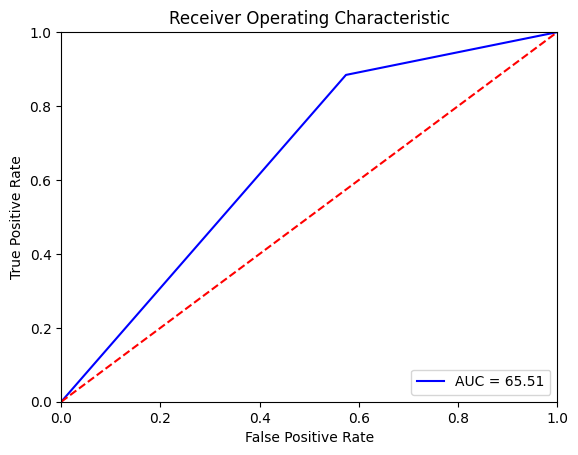

In [ ]:
from sklearn.metrics import classification_report
from sklearn. metrics import confusion_matrix

fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
print(plt.style.available)
plt.style.use('classic')

print(classification_report(y_test,y_test_pred))

<Axes: >

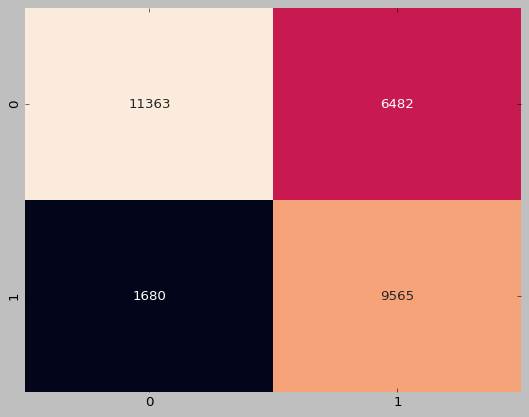

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True,fmt='d',cbar=False)

In [ ]:
#These are the log(P(cj))
class_logpriors= Bnb_model.class_log_prior_
class_logpriors

#These are the log(P(xi|cj))
logprobs = Bnb_model.feature_log_prob_
logprobs

np.exp(logprobs)

array([[0.42104025, 0.01840581, 0.01881744, 0.00067625, 0.00067625,
        0.01858222, 0.01905266, 0.01881744, 0.01811179, 0.01802358,
        0.01893505, 0.01843521, 0.01734733, 0.01940549, 0.01867043,
        0.01787657, 0.01864103, 0.01817059, 0.01908206, 0.01899385,
        0.01969951, 0.0182294 , 0.01893505, 0.01878804, 0.01925848,
        0.01931728, 0.01861163, 0.01922907, 0.01858222, 0.01881744,
        0.01922907, 0.01934668, 0.01896445, 0.01931728, 0.01664167,
        0.01902326, 0.01893505, 0.01914087, 0.01846461, 0.01875864,
        0.01937608, 0.01911146, 0.01878804, 0.01893505, 0.01922907,
        0.01919967, 0.01840581, 0.01896445, 0.01867043, 0.01887625,
        0.01881744, 0.00535121, 0.01849402, 0.01905266, 0.01893505,
        0.01896445, 0.01840581, 0.33468584, 0.33195143, 0.23218959,
        0.10123195, 0.00737997, 0.03892858, 0.0064685 , 0.03966364,
        0.04013407, 0.03240128, 0.00714475, 0.03892858, 0.03925201,
        0.04010467, 0.03948722, 0.0391638 , 0.03

In [ ]:
pd.DataFrame(data = logprobs, columns = dfw1.columns[1:99])

In [ ]:
pd.DataFrame(data = np.exp(logprobs), columns = dfw1.columns[1:99])

In [ ]:
y = BRFSS['Response'].values # this is still a bunch of strings
X = BRFSS.drop(['Response'],axis=1).values # this is also a bunnch of strings

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
ord_make = OrdinalEncoder()
X = ord_make.fit_transform(X)

lbl_make = LabelEncoder()
#y = lbl_make.fit_transform(y.reshape(-1,1)).reshape(-1,))
y = lbl_make.fit_transform(y)

In [ ]:
y

array([2, 3, 2, ..., 1, 0, 1])

In [ ]:
Catnb_model = CategoricalNB(alpha=1.0)
Catnb_model.fit(X, y);

In [ ]:
#These are the log(P(cj)), of course, same as before
class_log_priors=Catnb_model.class_log_prior_
class_log_priors

array([-0.69303374, -0.69326063])

In [ ]:
#These are the log(P(xi|cj)), also same as before
logprobs=Catnb_model.feature_log_prob_
logprobs

In [ ]:
# Some code to print the log conditional probabilities in a more legible manner:
listOfdfs=[]
dfX = BRFSS.drop(['Response'],axis=1)
for idx, feature in enumerate(dfX.columns):
  feature_vals = dfX[feature].unique()
  listOfdfs.append (pd.DataFrame(data = np.exp(logprobs[idx]), columns = feature_vals))

for dfi in listOfdfs:
  print(dfi,'\n')

In [ ]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

In [ ]:
#df_alc2.iloc[:, 1106:]

In [ ]:
df_alc2.columns

In [ ]:
#pd.set_option('display.max_rows', None)
#display(X_test, 30)
#pd.reset_option("max_rows")

In [ ]:
#Feature Importance:
scaler = StandardScaler() #MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(df_alc2, df_alc_target['Total Drinks Next Year'], test_size=0.33, random_state=0)
data_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
data_correlated = correlation(data_scaled, 0, df_alc_target['Total Drinks Next Year']) #
data_correlated_df = pd.DataFrame(data_correlated)
data_correlated_df2 = data_correlated_df.transpose() #Correlated inputs
X = df_alc2.loc[:, data_correlated_df2.columns] #get non scaled data with important features

#Train test split and scale:
X_train, X_test, y_train, y_test = train_test_split(X, df_alc_target['Total Drinks Next Year'], test_size=0.33, random_state=0) #split non-scaled important variables
X_train_processed = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_processed = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
correlated_scaled_data = pd.merge(X_test_processed, X_train_processed, how = 'outer')

#PCA:
pca=PCA(n_components = 9)
X_train_processed_PCA = pca.fit_transform(X_train_processed)
X_train_PCA_df = pd.DataFrame(X_train_processed_PCA)
X_test_processed_PCA = pca.fit_transform(X_test_processed)
X_test_PCA_df = pd.DataFrame(X_test_processed_PCA)
data_PCA = pd.merge(X_test_PCA_df, X_train_PCA_df, how = 'outer')
print("Principal axes:\n", pca.components_.tolist())
print("Explained variance:\n", pca.explained_variance_.tolist())
print("Mean:", pca.mean_)

#LLE:
#X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=5, random_state=42) #n_components=2 is default, neighbors 5 is default
X_unrolled_train = lle.fit_transform(X_train_processed)
X_train_LLE_df = pd.DataFrame(X_unrolled_train)
X_unrolled_test = lle.transform(X_test_processed)
X_test_LLE_df = pd.DataFrame(X_unrolled_test)
data_LLE = pd.merge(X_test_LLE_df, X_train_LLE_df, how = 'outer')

X = correlated_scaled_data #try correlated_scaled_data, data_PCA, or data_LLE
y = df_alc_target['Total Drinks Next Year']

In [ ]:
#Model: Alc Consumption AlcCons
RLE_Model(X, y, "Ridge") #19.9%, .3%, correlated
RLE_Model(X, y, "Lasso") #19.9%, .3%, correlated
SGD_model(X, y, 1e-3, 0.1) #19.9%, .3%, corr
GBR_model(X, y, .0001, 0.01, 100) #19.9%, .7%, corr
print("5:")
DTR_model(X, y, 100) #20.2%, .8%, corr

In [ ]:
SVM_rbf_model(X, y, "rbf", .1, 100) #20.3%, .7%, corr
SVM_rbf_model(X, y, "poly", .1, 100) #20.3%, .7%, corr
SVM_rbf_model(X, y, "linear", .1, 100) #20.3%, .7%, corr
SVM_model(X,y, 0) #

In [ ]:
RLE_Model(X, y, "Elastic") #19.9%, .3%, corr
BR_model(X,y) #
Keras_model(X, y, 400, 210, 200, 190, 100, 31) #19.9%, .3%, corr

In [ ]:
preds4 = RLE_Model(X, y, "Elastic") #19.9%, .302%, corr

In [ ]:
#Blender:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
print(data_correlated_df2.columns)
print()

preds = RLE_Model(X, y, "Lasso") #19.9%, .27%, correlated
preds2 = RLE_Model(X, y, "Ridge") #19.9%, .28%, correlated
preds3 = SGD_model(X, y, 1e-3, 0.1) #19.9%, .295%, corr
preds4 = RLE_Model(X, y, "Elastic") #19.9%, .302%, corr

#Get stats on blender
final_test_preds = (preds[0] + preds2[0] + preds3[0] + preds3[0])/4
final_train_preds = (preds[1] + preds2[1] + preds3[1] + preds4[1])/4 #20%, .5%
print("Blender test predictions:")
print(final_test_preds)
print()
print("Blender Train Scores then Test Scores:")
Scores(y_train, final_train_preds, y)
print()
Scores(y_test, final_test_preds, y)
print()